# Perceptrón multicapa

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar un perceptrón multicapa para la tarea de clasificación de imágenes. Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Tiene imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

![Lecun](../figs/yan_lecun.png)


## 1 Carga de datos

Comenzaremos descargando y leyendo el conjunto de datos. Aprovecharemos que torchvision cuenta con utilerias en para descargar el dataset MNIST.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(2019)

In [2]:
mnist_train = MNIST('~/.data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = MNIST('~/.data', train=False, transform=transforms.ToTensor())

Una vez descargadas las imágenes, podemos visualizar algunas para ver cómo lucen.

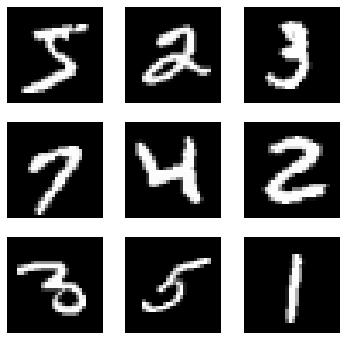

In [3]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

for i, axi in enumerate(ax.flat):
    axi.imshow(mnist_train.data[5 * i], cmap='gray')
    axi.set_axis_off()

Definimos nuestra tubería de datos para el conjunto de entrenamiento.

In [4]:
batch_size = 64
train_dl = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size=batch_size)

x, y_true = next(iter(train_dl))
print(f'x={x.numpy()} x.shape={x.shape}')
print(f'y_true={y_true.numpy()} y_true.shape={y_true.shape}')

x=[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0

### Quiz 1

¿Cúal es la función de activación adecuada para la capa de salida de una red neuronal para clasificación multiclase?

## 2 Definición del modelo

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
model = MLP().to(device)
model

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Quiz 2

¿Comó sacamos las cuentitas del número de parámeros de las capas?

### Quiz 3

Si las clases fueran 100 en vez de 10 y quisera utilizar la misma arquitectura anterior ¿qué modificación tendría que realizar? 

### Definición de pérdida y optimizador

In [7]:
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 3 Entrenamiento

In [8]:
tensorboard = False # cambiar si se quiere visualizar en tensorboard
# para visualizar tensorboard se abre una terminal y se ejecuta: tensorboard --logdir=mlp_runs
if tensorboard:
    writer = SummaryWriter('mlp_runs') 
    x, y = next(iter(train_dl))
    writer.add_graph(model, x)

# ciclo de entrenamiento
def corre_epoch(model, dl, loss_fn, optimizer, train=True):
    
    model.train() if train else model.eval()
    losses, accs = [], []
    
    with torch.set_grad_enabled(train):
        
        for x, y_true in dl:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y_true)
        
            if train:
                loss.mean().backward()
                optimizer.step()
                optimizer.zero_grad()
            
            losses.extend(loss.data.cpu().numpy())
            accs.extend((y_pred.argmax(-1) == y_true).cpu().numpy())
        
    return losses, accs

epochs = 20
for epoch in range(epochs):

    train_losses, train_accs = corre_epoch(model, train_dl, loss_fn, optimizer)
    val_losses, val_accs = corre_epoch(model, test_dl, loss_fn, optimizer, train=False)
    
    metrics = {'Loss': {'train': np.mean(train_losses), 'valid': np.mean(val_losses)},
               'Accuracy': {'train': np.mean(train_accs), 'valid': np.mean(val_accs)}}
        
    if tensorboard:
        for metric, partitions in metrics.items():
            for partition, value in partitions.items():
                writer.add_scalar(f'{metric}/{partition}', value, epoch)

    print(f'Epoch: {epoch+1:>2}. Train Loss: {np.mean(train_losses):.2f}, Train Acc: {np.mean(train_accs):.2%}. '
          f'Val Loss: {np.mean(val_losses):.4f}, Val Acc: {np.mean(val_accs):.2%}')

Epoch:  1. Train Loss: 2.22, Train Acc: 36.68%. Val Loss: 2.1333, Val Acc: 59.21%
Epoch:  2. Train Loss: 2.03, Train Acc: 65.23%. Val Loss: 1.8910, Val Acc: 70.46%
Epoch:  3. Train Loss: 1.75, Train Acc: 71.70%. Val Loss: 1.5773, Val Acc: 75.59%
Epoch:  4. Train Loss: 1.44, Train Acc: 76.15%. Val Loss: 1.2769, Val Acc: 78.81%
Epoch:  5. Train Loss: 1.18, Train Acc: 79.21%. Val Loss: 1.0470, Val Acc: 81.22%
Epoch:  6. Train Loss: 0.98, Train Acc: 81.36%. Val Loss: 0.8869, Val Acc: 82.69%
Epoch:  7. Train Loss: 0.85, Train Acc: 82.71%. Val Loss: 0.7755, Val Acc: 84.08%
Epoch:  8. Train Loss: 0.76, Train Acc: 83.82%. Val Loss: 0.6955, Val Acc: 85.12%
Epoch:  9. Train Loss: 0.69, Train Acc: 84.65%. Val Loss: 0.6362, Val Acc: 85.93%
Epoch: 10. Train Loss: 0.63, Train Acc: 85.41%. Val Loss: 0.5902, Val Acc: 86.54%
Epoch: 11. Train Loss: 0.59, Train Acc: 86.02%. Val Loss: 0.5541, Val Acc: 87.08%
Epoch: 12. Train Loss: 0.56, Train Acc: 86.52%. Val Loss: 0.5247, Val Acc: 87.45%
Epoch: 13. Train

## 4 Validación

In [9]:
y_pred_test = []
with torch.no_grad():
    for x, _ in test_dl:
        x = x.to(device)
        y_pred = model(x).cpu().numpy()
        y_pred_test.extend(y_pred)
y_pred_test = np.array(y_pred_test)

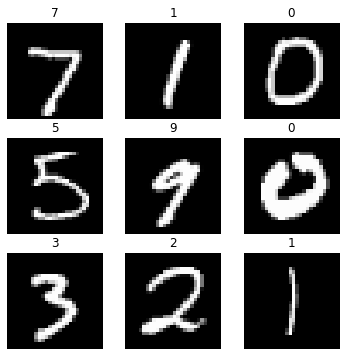

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

for i, axi in enumerate(ax.flat):
    axi.imshow(mnist_test.data[5*i], cmap='gray')
    axi.set_axis_off()
    axi.set_title(f'{y_pred_test[5*i].argmax()}')